In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
airport = pd.read_csv("airports.csv", header=None, dtype=str)
airport.columns = ['id', 'name', 'city', 'country', 'code', 
                   'icao', 'latitude', 'longitude', 'altitude',
                   'offset', 'dst', 'timezone']

airlines = pd.read_csv("airlines.csv", header=None, dtype=str)
airlines.columns = ['id', 'name', 'alias', 'iata', 'icao', 'callsign', 'country', 'active']

routes = pd.read_csv("routes.csv", header=None, dtype=str)
routes.columns = ['airline', 'airline_id', 'source', 'source_id', 
                  'dest', 'dest_id', 'codeshare', 'stops', 'equipment']

In [3]:
airport.head()

,id,name,city,country,code,icao,latitude,longitude,altitude,offset,dst,timezone
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.0816898346,145.391998291,5282,10,U,Pacific/Port_Moresby
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.2070798874,145.789001465,20,10,U,Pacific/Port_Moresby
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826789856,144.296005249,5388,10,U,Pacific/Port_Moresby
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.4433803558,147.2200012207,146,10,U,Pacific/Port_Moresby


In [4]:
airlines.head()

,id,name,alias,iata,icao,callsign,country,active
0,-1,Unknown,\N,-,NaN,\N,\N,Y
1,1,Private flight,\N,-,NaN,NaN,NaN,Y
2,2,135 Airways,\N,NaN,GNL,GENERAL,United States,N
3,3,1Time Airline,\N,1T,RNX,NEXTIME,South Africa,Y
4,4,2 Sqn No 1 Elementary Flying Training School,\N,NaN,WYT,NaN,United Kingdom,N


In [5]:
routes.head()

,airline,airline_id,source,source_id,dest,dest_id,codeshare,stops,equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


The following line ensure that we have only numeric data in airline_id

In [6]:
routes = routes[routes['airline_id'] != "\\N"]

# Histogram
Showing the distribution of route lengths by airlines. A histogram divides all the route lengths into ranges (or "bins"), and counts how many routes fall into each range. This can tell us if airlines fly more shorter routes, or more longer ones. <br />
The first step is a distance formula. We'll use __haversine distance__, which calculates the distance between latitude, longitude pairs. <br />

a = sin²(dlat/2) + cos lat1 ⋅ cos lat2 ⋅ sin²(dlon/2)
<br />
c = 2 * math.asin(math.sqrt(a)) 
<br />
km = R.c
<br /><br />
where, dlat is latitude, <br />
dlon is longitude, <br />
R is earth’s radius (mean radius = 6,371km)

In [7]:
import math

def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = [float(lon1), float(lat1), float(lon2), float(lat2)]
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    # Distance
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    km = 6371 * c
    return km

Now the following function calculates the distance between the source and destination airports for a single route.<br />
To do this, we need to get the source_id and dest_id airports from the routes dataframe, then match them up with the id column in the airports dataframe to get the latitude and longitude of those airports. Then, it's just a matter of doing the calculation.

In [8]:
def calc_dist(row):
    dist = 0
    try:
        source = airport[airport['id'] == row['source_id']].iloc[0]
        dest = airport[airport['id'] == row['dest_id']].iloc[0]
        dist = haversine(dest['longitude'], dest['latitude'], source['longitude'], source['latitude'])
    except (ValueError, IndexError):
        pass
    return dist

In [9]:
route_lengths = routes.apply(calc_dist, axis=1)

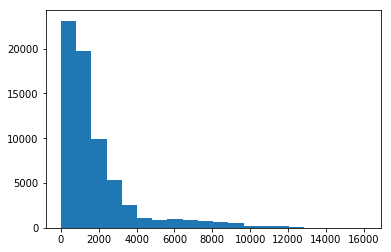

In [10]:
plt.hist(route_lengths, bins=20)
plt.show()

Seaborn, a higher level plotting library

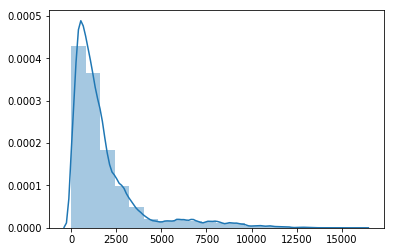

In [11]:
import seaborn as sns
sns.distplot(route_lengths, bins=20)

# Bar charts
Lets see the average route length by airline. So here we can use bar chart which will have an individual bar for each airline.

In [12]:
route_length_df = pd.DataFrame({'length': route_lengths, 'id': routes['airline_id']})
airline_route_lengths = route_length_df.groupby('id').aggregate(np.mean)
airline_route_lengths = airline_route_lengths.sort_values('length', ascending=False)

<Container object of 547 artists>

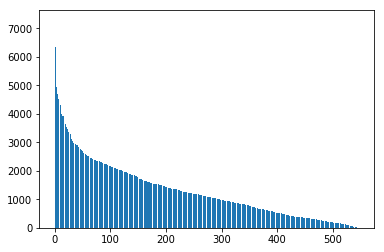

In [13]:
plt.bar(range(airline_route_lengths.shape[0]), airline_route_lengths['length'])

Here we can't make out which airlines has what route length. So we will make use of bokeh, to make plot interactive by adding zoom in and out functions.

# Horizontal bar charts
Now we will make use of python data analysis library __Pygal__ that makes attractive charts quickly. <br />
We will now make a breakdown of route length in short, medium and long.

In [14]:
long_routes = len([k for k in route_lengths if k > 10000]) / len(route_lengths)
medium_routes = len([k for k in route_lengths if k < 10000 and k > 2000]) / len(route_lengths)
short_routes = len([k for k in route_lengths if k < 2000]) / len(route_lengths)

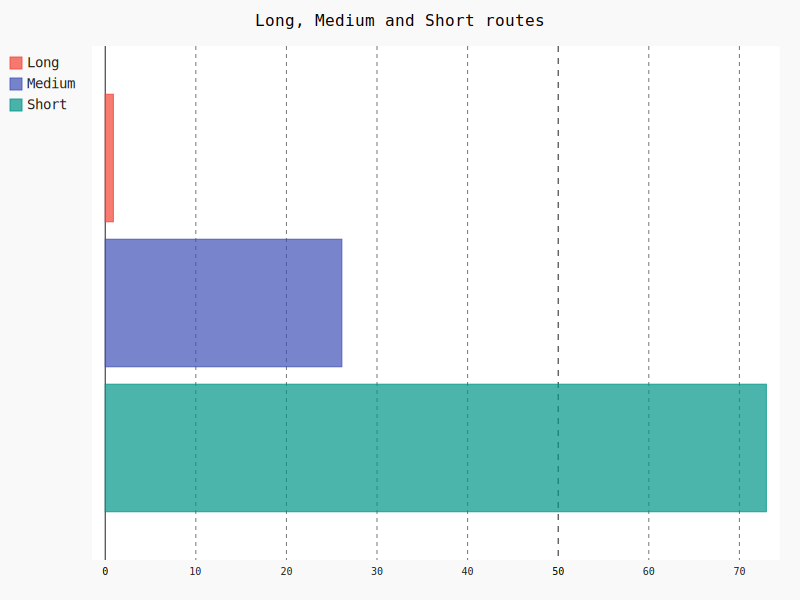

In [15]:
import pygal
from IPython.display import SVG

chart = pygal.HorizontalBar()
chart.title = 'Long, Medium and Short routes'
chart.add('Long', long_routes * 100)
chart.add('Medium', medium_routes * 100)
chart.add('Short', short_routes * 100)
chart.render_to_file('routes_breakdown.svg')
SVG(filename='routes_breakdown.svg')

# Scatter Plot
It enable us to compare columns of data.

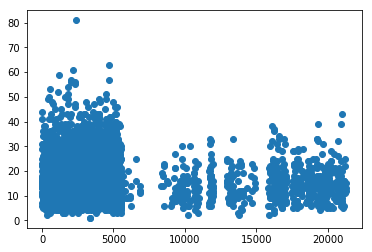

In [16]:
# Here, we make a simple scatter plot to compare airline id number to length of airline names

name_lengths = airlines['name'].apply(lambda x: len(str(x)))
plt.scatter(airlines['id'].astype(int), name_lengths)

Let's verify using seaborn. <br />
Seaborn has an augmented version of a scatterplot, a joint plot, that shows how correlated the two variables are, as well as the individual distributions of each.

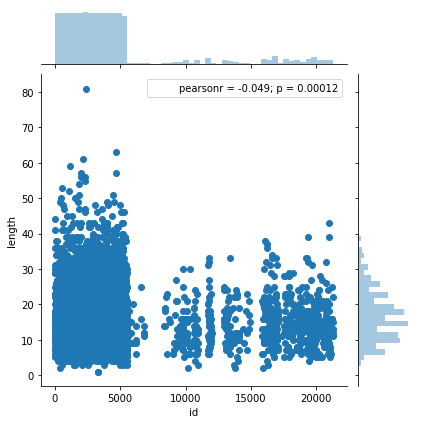

In [17]:
data = pd.DataFrame({'length':name_lengths, 'id':airlines['id'].astype(int)})
sns.jointplot(x='id', y='length', data=data)

The above plot shows that there isn't any real correlation between the two variables -- the r squared value is low.

# Static Maps

/home/vipul/DataScience/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1623: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  fill_color = ax.get_axis_bgcolor()
/home/vipul/DataScience/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
/home/vipul/DataScience/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/vipul/DataScience/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


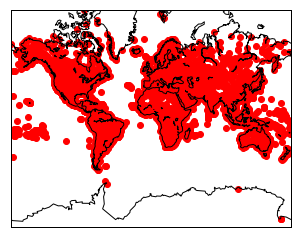

In [18]:
from mpl_toolkits.basemap import Basemap

# Create a map
m = Basemap(projection='merc', llcrnrlat=-80, urcrnrlat=80,
            llcrnrlon=-180, urcrnrlon=180, lat_ts=20, resolution='c')
m.drawcoastlines()
m.drawmapboundary()

# Convert latitude and longitude to x and y coordinate
x, y = m(list(airport['longitude'].astype(float)), list(airport['latitude'].astype(float)))
m.scatter(x, y, marker='o',color='red')